## Brillouin-Wigner correction of the quasiparticle Hamiltonian

We approach and analyze the structure of the corrections and the properties of these effective Hamiltonians using both the nn-pp quasiparticle and the nn-pp/ np quasiparticle frameworks.

### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp framework

#### Imports

In [123]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [ ]:
file_name='data/usdb.nat' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Set the specific nucleus

In [ ]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=2
nparticles_b=10
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{28}$Ne'



Compute the NSM Hamiltonian

In [132]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=3)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 19541.58it/s]

✅ Two-body operator built: shape=(81, 81), nnz=2757
[-23.93429271 -22.12259552 -20.17353312]
(81, 81)


Plot the NSM Hamiltonian

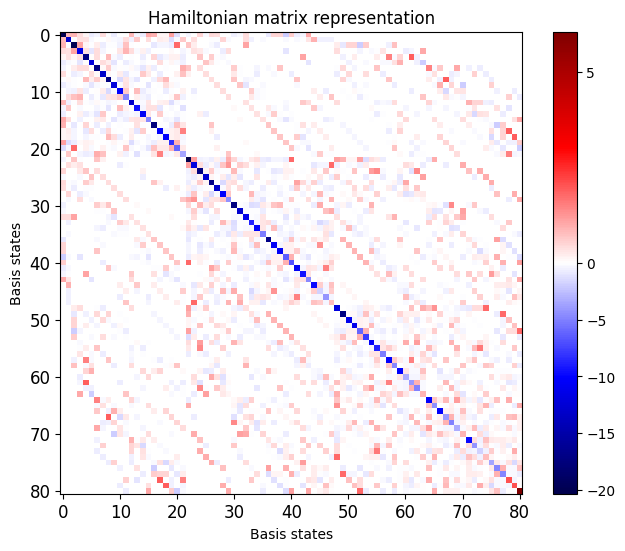

In [133]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In [134]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(15, 12)
(66, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [135]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


Plot the Quasiparticle Hamiltonian

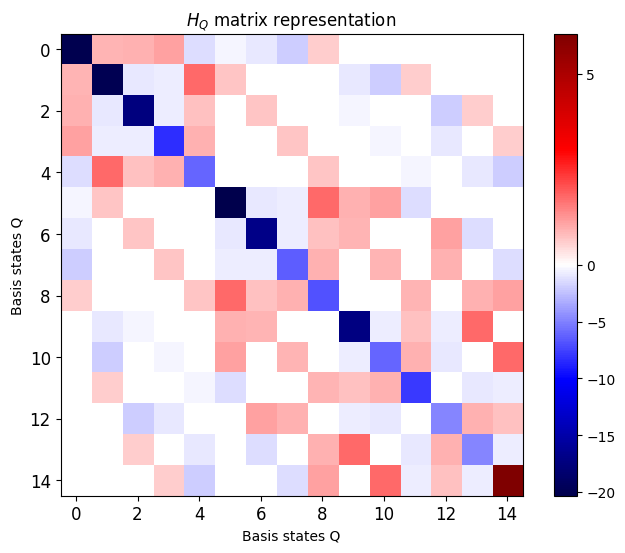

In [136]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [137]:
print(QPC.couples)

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]


In [138]:
count=0
for key in twobody_matrix.keys():
    a,b,c,d=key
    
    if [min(a,b),max(a,b)] in QPC.couples or [min(c,d),max(c,d)] in QPC.couples:
        continue
    else:
        count+=1
        
print(f'Number of non quasiaparticle two-body matrix elements: {count/len(twobody_matrix)}')

Number of non quasiaparticle two-body matrix elements: 0.9437439379243453


### Exact Brillouin-Wigner method

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [139]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        #diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        #single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_full_brillouinwigner_method=[]
interaction_terms_full_brillouinwigner_method=[]
infidelities_full_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_full_brillouinwigner_method.append(1-fidelity)
    history_errors_full_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
    

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 480.85it/s]

-23.934265697372265
1.1285441899289884e-06 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

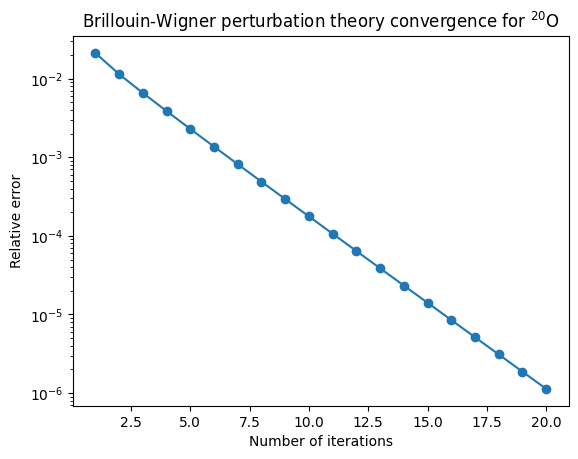

In [140]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.show()

##### Fit of the curve

Model results (lower SSE and higher R2 are better):

power (logreg):
  params: (np.float64(0.2304615917120436), np.float64(3.494434983425527))
  SSE=4.385e-02, R2=-81.6005

exp:
  params: [0.0375814  0.57730196]
  stderr: [0.00042123 0.00669311]
  SSE=3.523e-07, R2=0.9993

stretched_exp:
  params: [0.04590594 0.73368018 0.84583543]
  stderr: [0.00063669 0.01263946 0.00866198]
  SSE=1.904e-08, R2=1.0000

power*exp:
  params: [0.03408802 0.21204558 0.47134705]
  stderr: [7.96986767e-05 4.69939253e-03 2.36857040e-03]
  SSE=3.116e-09, R2=1.0000


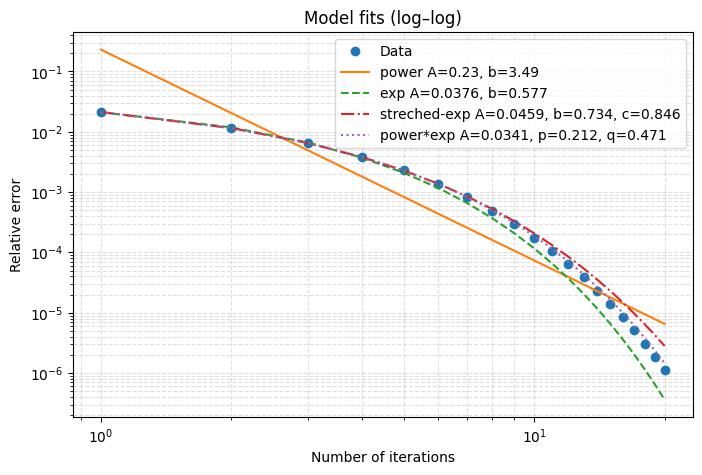

Best breakpoint (simple split) at k=4 (1-based iteration 4), total SSE=1.520e-05


In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# --- data: replace with your variables ---
x = np.arange(1, nsteps_iteration + 1)
y = np.array(history_errors_full_brillouinwigner_method)

# avoid zeros or negative y when taking logs
eps = 1e-300
y = np.clip(y, eps, None)

# --- model definitions ---
def power_model(x, A, b):
    return A * x**(-b)

def exp_model(x, A, b):
    return A * np.exp(-b * x)

def stretched_exp(x, A, b, c):
    # A * exp( - (b*x)^c )
    return A * np.exp(- (b * x)**c)

def power_times_exp(x, A, p, q):
    # A * x^{-p} * exp(-q * x)
    return A * x**(-p) * np.exp(-q * x)

# --- fitting helper that wraps curve_fit with bounds and initial guesses ---
def fit_curve(model, xdata, ydata, p0=None, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(model, xdata, ydata, p0=p0, bounds=bounds, maxfev=100000)
        residuals = ydata - model(xdata, *popt)
        sse = np.sum(residuals**2)
        # R^2 on y (not on log) as a simple metric
        ss_tot = np.sum((ydata - np.mean(ydata))**2)
        r2 = 1 - sse / ss_tot if ss_tot > 0 else np.nan
        return popt, np.sqrt(np.diag(pcov)), sse, r2
    except Exception as e:
        print("Fit failed for", model.__name__, ":", e)
        return None, None, np.inf, np.nan

# --- Fit models ---
results = {}

# 1) Power law: fit by linear regression on log-log (more stable)
X = np.log(x)
Y = np.log(y)
slope, intercept, rval, pval, stderr = linregress(X, Y)
b_power = -slope
A_power = np.exp(intercept)
# compute sse/r2 for consistency with other fits
y_power_pred = power_model(x, A_power, b_power)
sse_power = np.sum((y - y_power_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_power = 1 - sse_power / ss_tot
results['power (logreg)'] = ((A_power, b_power), None, sse_power, r2_power)

# 2) Exponential (nonlinear fit)
p0 = [y[0], 0.5]  # initial A and b
popt, perr, sse, r2 = fit_curve(exp_model, x, y, p0=p0, bounds=([0,0],[np.inf,np.inf]))
results['exp'] = (popt, perr, sse, r2)

# 3) Stretched exponential
# sensible initial guesses: A ~ y0, b ~ 0.5/x_mean, c ~ 1
p0 = [y[0], 0.1, 0.0]
bounds = ([0, 0, 0], [np.inf, np.inf, 5])  # restrict c to positive
popt_se, perr_se, sse_se, r2_se = fit_curve(stretched_exp, x, y, p0=p0, bounds=bounds)
results['stretched_exp'] = (popt_se, perr_se, sse_se, r2_se)

# 4) power * exponential
p0 = [y[0], 0.5, 0.1]
bounds = ([0, 0, 0], [np.inf, 5, np.inf])
popt_pe, perr_pe, sse_pe, r2_pe = fit_curve(power_times_exp, x, y, p0=p0, bounds=bounds)
results['power*exp'] = (popt_pe, perr_pe, sse_pe, r2_pe)

# --- Print results ---
print("Model results (lower SSE and higher R2 are better):")
for name, (popt, perr, sse, r2) in results.items():
    print(f"\n{name}:")
    if popt is None:
        print("  fit failed")
    else:
        print("  params:", popt)
        if perr is not None:
            print("  stderr:", perr)
        print(f"  SSE={sse:.3e}, R2={r2:.4f}")

# --- Plot data and model fits ---
plt.figure(figsize=(8,5))
plt.loglog(x, y, 'o', label='Data')

# Power-law (from logreg)
plt.loglog(x, y_power_pred, '-', label=f'power A={A_power:.3g}, b={b_power:.3g}')

# Exponential (if fit succeeded)
if results['exp'][0] is not None:
    Aexp, bexp = results['exp'][0]
    plt.loglog(x, exp_model(x, Aexp, bexp), '--', label=f'exp A={Aexp:.3g}, b={bexp:.3g}')

# Stretched exponential
if results['stretched_exp'][0] is not None:
    Ase, bse, cse = results['stretched_exp'][0]
    plt.loglog(x, stretched_exp(x, Ase, bse, cse), '-.', label=f'streched-exp A={Ase:.3g}, b={bse:.3g}, c={cse:.3g}')

# power * exp
if results['power*exp'][0] is not None:
    Ape, ppe, qpe = results['power*exp'][0]
    plt.loglog(x, power_times_exp(x, Ape, ppe, qpe), ':', label=f'power*exp A={Ape:.3g}, p={ppe:.3g}, q={qpe:.3g}')

plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title('Model fits (log–log)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# --- Optional: check for a breakpoint (simple brute-force) ---
# Try splitting the data at every candidate k and fit power-laws to left/right segments,
# pick k that minimizes total SSE.
xmin_seg = 3  # minimum points in a segment
best_k, best_sse = None, np.inf
for k in range(xmin_seg, len(x)-xmin_seg):
    # fit left (log-linear)
    xl, yl = x[:k], y[:k]
    Xl, Yl = np.log(xl), np.log(yl)
    slope_l, intercept_l, *_ = linregress(Xl, Yl)
    Al, bl = np.exp(intercept_l), -slope_l
    pred_l = power_model(xl, Al, bl)
    sse_l = np.sum((yl - pred_l)**2)
    # fit right
    xr, yr = x[k:], y[k:]
    Xr, Yr = np.log(xr), np.log(yr)
    slope_r, intercept_r, *_ = linregress(Xr, Yr)
    Ar, br = np.exp(intercept_r), -slope_r
    pred_r = power_model(xr, Ar, br)
    sse_r = np.sum((yr - pred_r)**2)
    if sse_l + sse_r < best_sse:
        best_sse = sse_l + sse_r
        best_k = k

print(f"Best breakpoint (simple split) at k={best_k} (1-based iteration {best_k}), total SSE={best_sse:.3e}")


##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

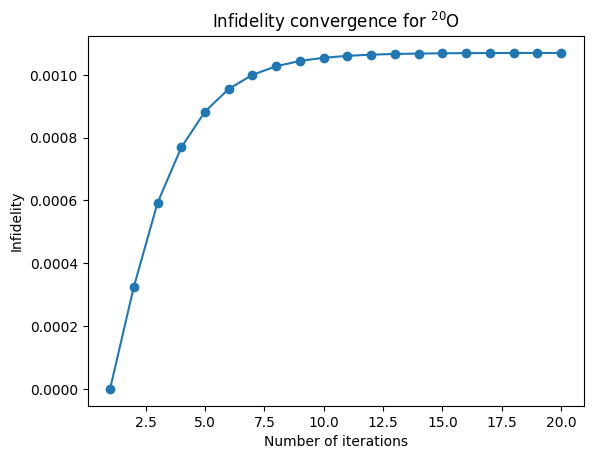

In [142]:
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [143]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_full_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-23.92671484]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

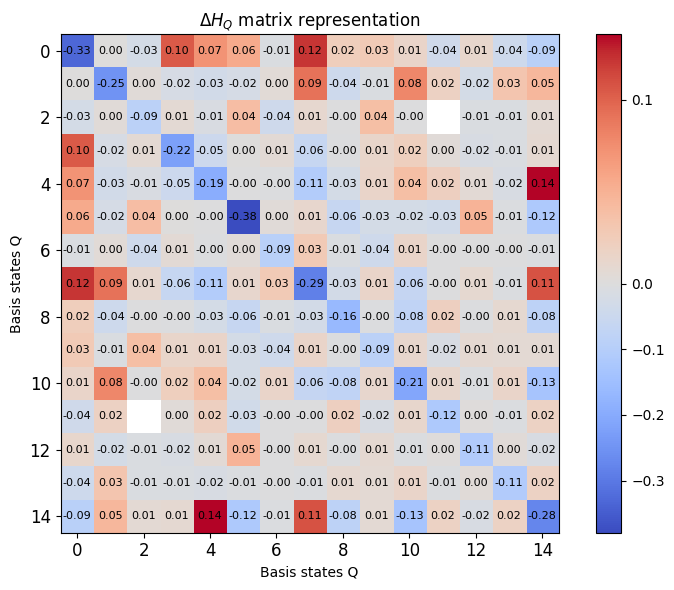

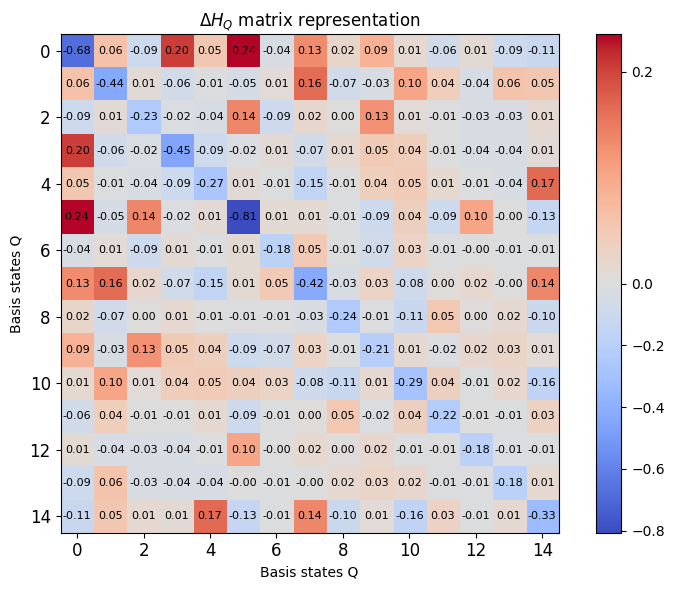

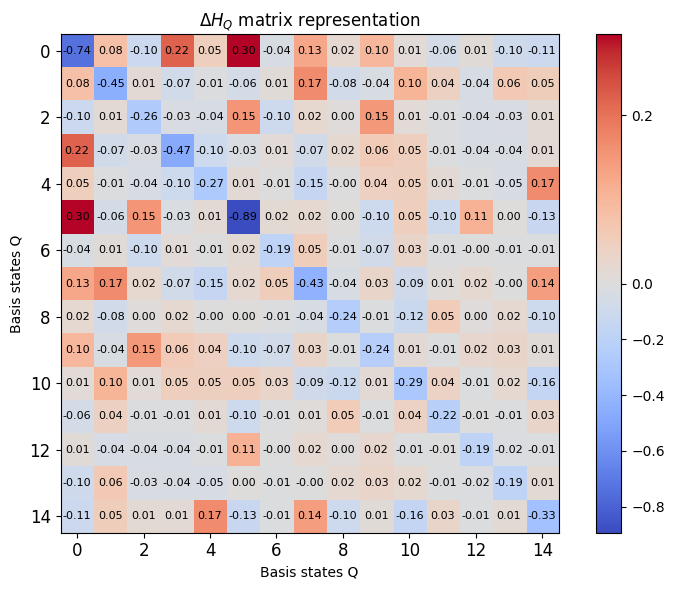

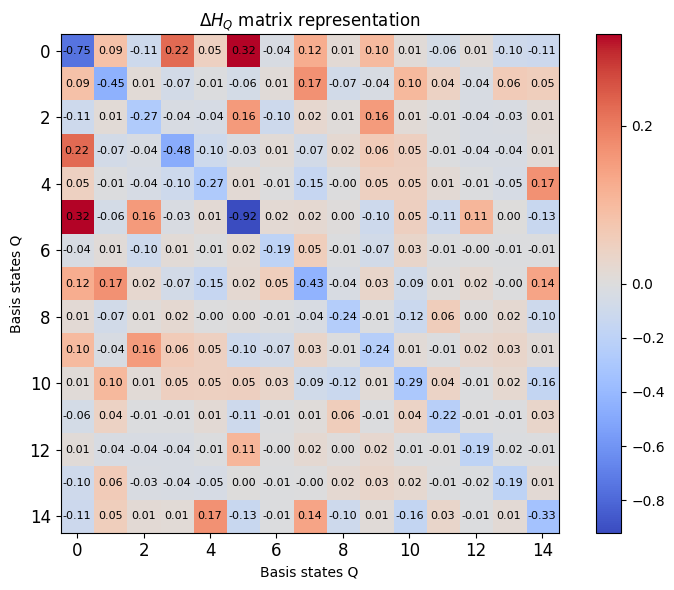

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_full_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [146]:
count_0=0
count_1=0
count_2=0
count_3=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_3+=1
print(count_0,count_1//2,count_2//2,count_3//2)

15 60 45 0


### Brillouin-Wigner method with mean field approximation of $H_{RR}$

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [147]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_meanfield_brillouinwigner_method=[]
interaction_terms_meanfield_brillouinwigner_method=[]
infidelities_meanfield_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_meanfield_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 548.43it/s]

-23.86837593746987
0.0027540722265240835 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

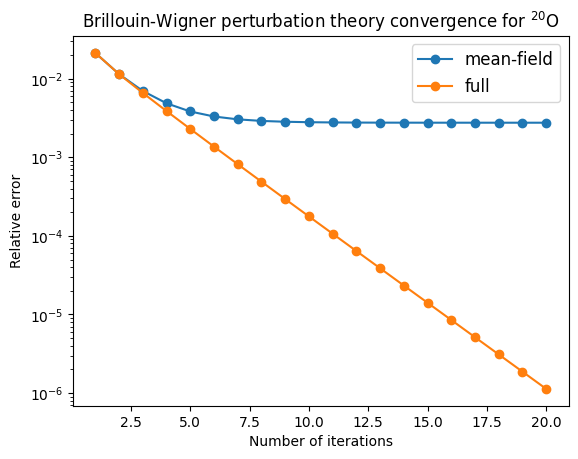

In [148]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')

plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

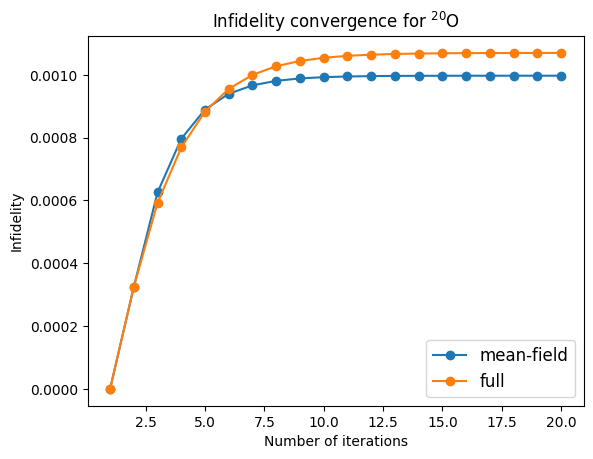

In [149]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [150]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-23.86122384]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

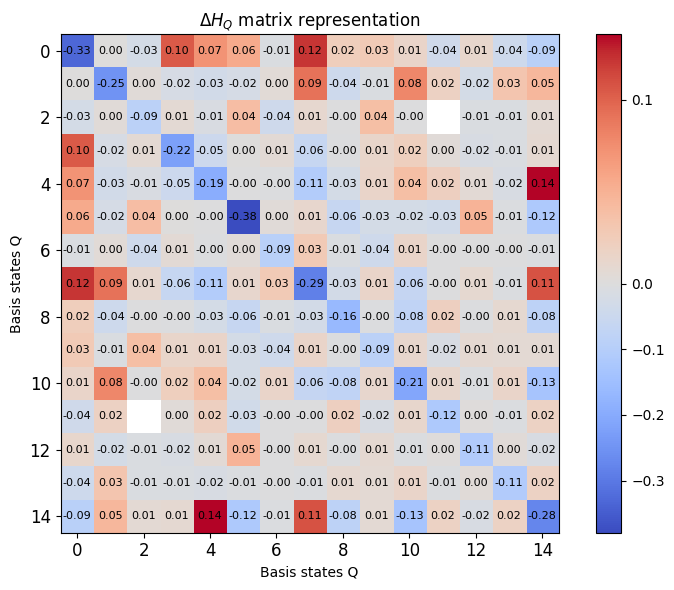

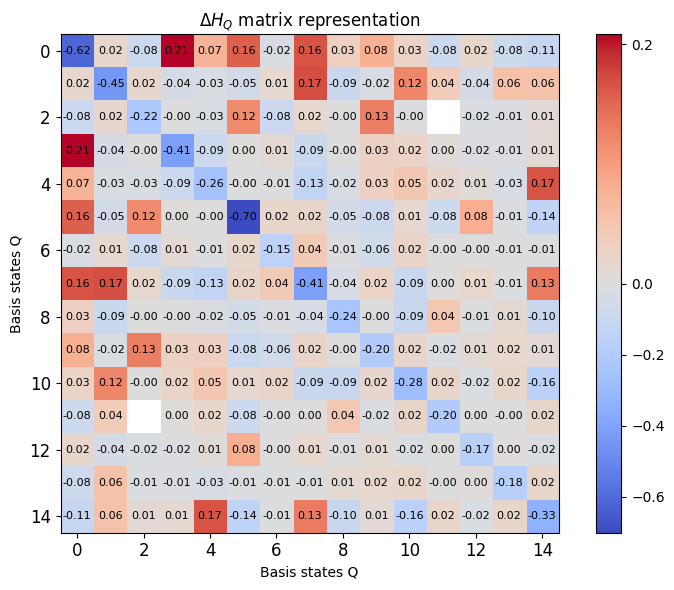

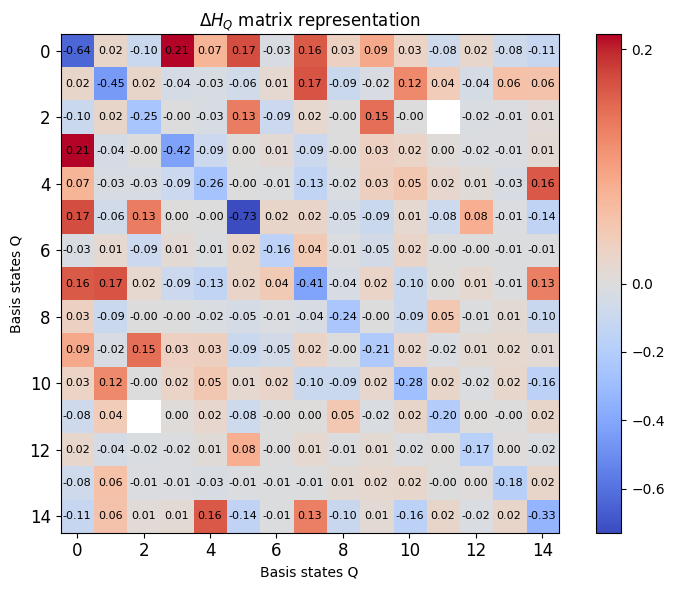

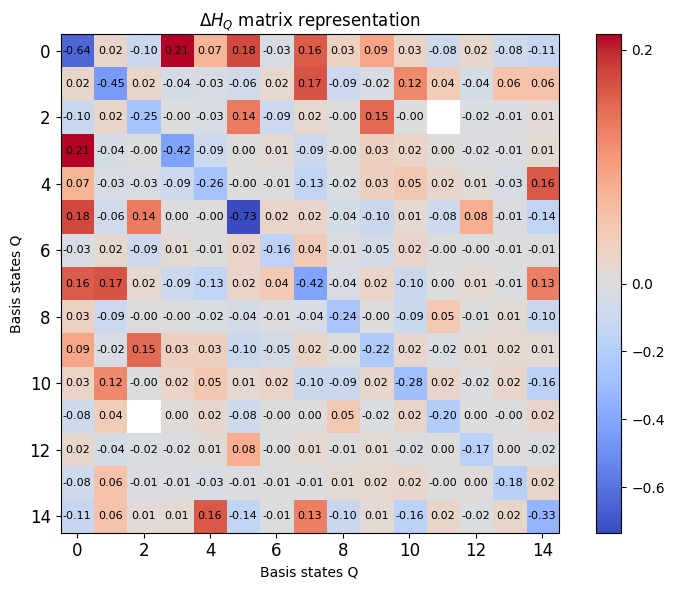

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_meanfield_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [122]:
count_0=0
count_1=0
count_2=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1

print(count_0,count_1//2,count_2//2)

9 18 18
